In [29]:
from datetime import datetime
import numpy as np
import sklearn.metrics
import tensorflow as tf
import itertools
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_hub as hub
import zipfile
import os
from packaging import version



In [30]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm

K = keras.backend
#Source
# https://github.com/benihime91/one_cycle_lr-tensorflow

class Scheduler:
    def __init__(self, vals, n_iter: int) -> None:
        'Used to "step" from start,end (`vals`) over `n_iter` s on a schedule defined by `func`'
        self.start, self.end = (
            (vals[0], vals[1]) if isinstance(vals, tuple) else (vals, 0)
        )
        self.n_iter = max(1, n_iter)
        self.func = self._aannealing_exp
        self.n = 0

    @staticmethod
    def _aannealing_exp(start: float, end: float, pct: float) -> float:
        "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        return start * (end / start) ** pct

    def restart(self) -> None:
        self.n = 0

    def step(self) -> float:
        self.n += 1
        return self.func(self.start, self.end, self.n / self.n_iter)

    @property
    def is_done(self) -> bool:
        "Return `True` if schedule completed."
        return self.n >= self.n_iter


class LrFinder:
    """
    [LrFinder Implemetation taken from Fast.ai]
    (https://github.com/fastai/fastai/tree/master/fastai)

    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.

    Args:
    model (tf.keras.Model): wrapped model
    optimizer (tf.keras.optimizers): wrapped optimizer
    loss_fn (tf.keras.losses): loss function

    Example:
        >>> lr_finder = LrFinder(model, optimizer, loss_fn)
        >>> lr_finder.range_test(trn_ds, end_lr=100, num_iter=100)
        >>> lr_finder.plot_lrs() # to inspect the loss-learning rate graph
    """

    def __init__(self,
                 model: tf.keras.Model,
                 optimizer: tf.keras.optimizers.Optimizer,
                 loss_fn: tf.keras.losses.Loss,
                 ) -> None:

        self.lrs = []
        self.losses = []
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.mw = self.model.get_weights()
        self.init_lr = K.get_value(self.optimizer.lr)
        self.iteration = 0
        self.weightsFile = tempfile.mkstemp()[1]

    @tf.function
    def trn_step(self, xb, yb):
        """performs 1 trainig step"""
        with tf.GradientTape() as tape:
            logits = self.model(xb, training=True)
            main_loss = tf.reduce_mean(self.loss_fn(yb, logits))
            loss = tf.add_n([main_loss] + self.model.losses)
        grads = tape.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def range_test(self,
                   trn_ds: tf.data.Dataset,
                   start_lr: float = 1e-7,
                   end_lr: float = 10,
                   num_iter: int = 100,
                   beta=0.98,
                   ) -> None:
        """
        Explore lr from `start_lr` to `end_lr` over `num_it` s in `model`.

        Args:
        trn_ds (tf.data.Dataset)
        start_lr (float, optional): the starting learning rate for the range test.
                Default:1e-07.
        end_lr (float, optional): the maximum learning rate to test. Default: 10.
        num_iter (int, optional): the number of s over which the test
                occurs. Default: 100.
        beta (float, optional): the loss smoothing factor within the [0, 1]
                interval. The loss is smoothed using exponential smoothing.
                Default: 0.98.
        """
        # save original model weights
        try:
            self.model.save_weights(self.weightsFile)
        except:
            print("Unable to save initial weights, weights of model will change. Re-instantiate model to load previous weights ...")
        # start scheduler
        sched = Scheduler((start_lr, end_lr), num_iter)
        avg_loss, best_loss, = 0.0, 0.0
        # set the startig lr
        K.set_value(self.optimizer.lr, sched.start)

        print(f"Finding best initial lr over {num_iter} steps")
        # initialize tqdm bar
        bar = tqdm(iterable=range(num_iter))

        # iterate over the batches
        for (xb, yb) in trn_ds:
            self.iteration += 1
            loss, grads = self.trn_step(xb, yb)
            # compute smoothed loss
            avg_loss = beta * avg_loss + (1 - beta) * loss
            smoothed_loss = avg_loss / (1 - beta ** self.iteration)

            # record best loss
            if self.iteration == 1 or smoothed_loss < best_loss:
                best_loss = smoothed_loss

            # stop if loss is exploding
            if sched.is_done or (
                smoothed_loss > 4 * best_loss or np.isnan(smoothed_loss)
            ):
                break

            # append losses and lrs
            self.losses.append(smoothed_loss)
            self.lrs.append(K.get_value(self.optimizer.lr))

            # update weights
            self.optimizer.apply_gradients(
                zip(grads, self.model.trainable_variables))

            # update lr
            K.set_value(self.optimizer.lr, sched.step())

            # update tqdm
            bar.update(1)

        # clean-up
        bar.close()
        sched.restart()
        self._print_prompt()

    def _print_prompt(self) -> None:
        "Cleanup model weights disturbed during LRFinder exploration."
        try:
            self.model.load_weights(self.weightsFile)
        except:
            print(
                "Unable to load inital weights. Re-instantiate model to load previous weights ...")
        K.set_value(self.optimizer.lr, self.init_lr)
        print(
            "LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.")

    @staticmethod
    def _split_list(vals, skip_start: int, skip_end: int) -> list:
        return vals[skip_start:-skip_end] if skip_end > 0 else vals[skip_start:]

    def plot_lrs(self,
                 skip_start: int = 10,
                 skip_end: int = 5,
                 suggestion: bool = False,
                 show_grid: bool = False,
                 ) -> None:
        """
        Plot learning rate and losses, trimmed between `skip_start` and `skip_end`.
        Optionally plot and return min gradient
        """
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        losses = self._split_list(self.losses, skip_start, skip_end)
        _, ax = plt.subplots(1, 1)
        ax.plot(lrs, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel("Learning Rate")
        ax.set_xscale("log")
        if show_grid:
            plt.grid(True, which="both", ls="-")
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.0e"))
        if suggestion:
            try:
                mg = (np.gradient(np.array(losses))).argmin()
            except:
                print(
                    "Failed to compute the gradients, there might not be enough points."
                )
                return
            print(f"Min numerical gradient: {lrs[mg]:.2E}")
            ax.plot(lrs[mg], losses[mg], markersize=10,
                    marker="o", color="red")
            self.min_grad_lr = lrs[mg]
            ml = np.argmin(losses)
            print(f"Min loss divided by 10: {lrs[ml]/10:.2E}")

In [31]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [32]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
zip_ref = zipfile.ZipFile("drive/MyDrive/data_5cls_0.7.zip", 'r')
zip_ref.extractall(os.curdir)
zip_ref.close()

In [34]:
class_names = ['capacitor', 'diode', 'ic', 'inductor','resistor']
# class_names = ['capacitor', 'inductor','resistor']

num_classes = len(class_names)

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))



In [35]:
model_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}

handle_base, pixels, FV_SIZE = model_selection

IMAGE_SIZE = (pixels, pixels)

# if you are running the notebook on Colab
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

# # if you are running the notebook on your local machine
# MODULE_HANDLE ="./models/tf2-preview_mobilenet_v2_feature_vector_4".format(handle_base)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   trainable=False)

print("Using {} with input size {} and output dimension {}.".format(handle_base, IMAGE_SIZE, FV_SIZE))

Using mobilenet_v2 with input size (224, 224) and output dimension 1280.


In [36]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(224,224,3)),
        # tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        # tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.2,0.3),(-0.2,0.3)),
        # tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
        # tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
        feature_extractor,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



TRAINING_DIR = 'data_5cls_0.7/train'
training_datagen = ImageDataGenerator(
      rescale = 1./255.0,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      # # validation_split=0.2)
	    rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      # # shear_range=0.2,
      # # zoom_range=0.2,
      # # horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = 'data_5cls_0.7/validation'
validation_datagen = ImageDataGenerator(rescale = 1./255.0)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32)


validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32)



Found 1750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


In [38]:
# Import LrFinder


# Instantiate Optimizer & loss_fn
# [must be instance of tf.keras.Optimizers & tf.keras.Losses]
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()



# Instantiate LrFinder
lr_find = LrFinder(model, optimizer, loss_fn)

# Start range_test
lr_find.range_test(train_generator)


Finding best initial lr over 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.


Min numerical gradient: 1.32E-02
Min loss divided by 10: 3.02E-02


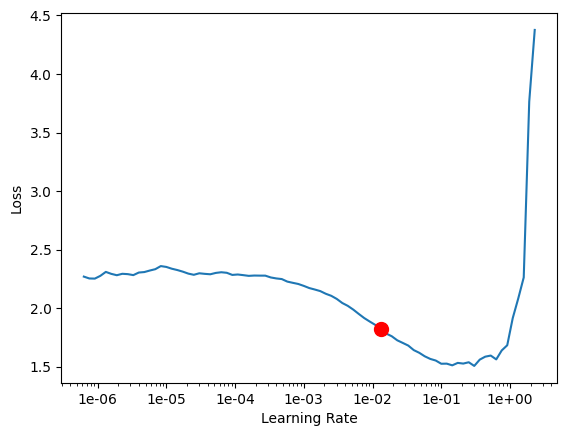

In [39]:
lr_find.plot_lrs(skip_end=0, suggestion=True)

In [40]:
from datetime import datetime
log_dir = "logs/"+ datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [42]:
learning_rate = 1e-02
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [43]:
history = model.fit(train_generator,
          epochs=10,
          batch_size=32,
          validation_data=validation_generator,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/10
55/55 [==============================] - 35s 506ms/step - loss: 0.6930 - accuracy: 0.7897 - val_loss: 0.3370 - val_accuracy: 0.8800
Epoch 2/10
55/55 [==============================] - 29s 524ms/step - loss: 0.3253 - accuracy: 0.8937 - val_loss: 0.3131 - val_accuracy: 0.9147
Epoch 3/10
55/55 [==============================] - 26s 475ms/step - loss: 0.2139 - accuracy: 0.9297 - val_loss: 0.2455 - val_accuracy: 0.9293
Epoch 4/10
55/55 [==============================] - 29s 529ms/step - loss: 0.2291 - accuracy: 0.9326 - val_loss: 0.2069 - val_accuracy: 0.9400
Epoch 5/10
55/55 [==============================] - 27s 489ms/step - loss: 0.2249 - accuracy: 0.9303 - val_loss: 0.3340 - val_accuracy: 0.9133
Epoch 6/10
55/55 [==============================] - 26s 476ms/step - loss: 0.2442 - accuracy: 0.9206 - val_loss: 0.2707 - val_accuracy: 0.9347
Epoch 7/10
55/55 [==============================] - 27s 496ms/step - loss: 0.2770 - accuracy: 0.9217 - val_loss: 0.3054 - val_accuracy: 0.9280

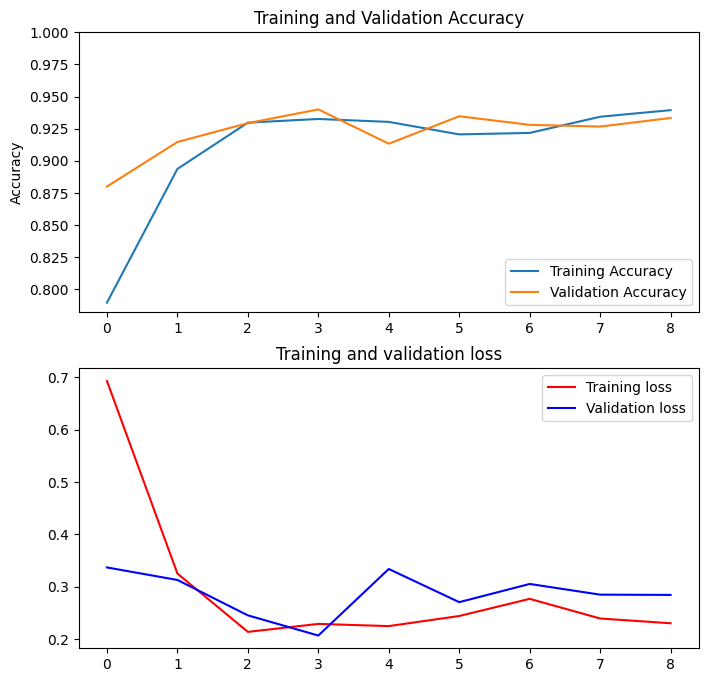

<Figure size 640x480 with 0 Axes>

In [44]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Saving Capacitor (4756).jpg to Capacitor (4756) (2).jpg
Saving Capacitor (4764).jpg to Capacitor (4764) (2).jpg
Saving diodaIN5408114.jpg to diodaIN5408114 (2).jpg
Saving diodaIN5408175.jpg to diodaIN5408175 (2).jpg
Saving IC (720).jpg to IC (720) (2).jpg
Saving IC (744).jpg to IC (744) (2).jpg
Saving induction-coil019.jpg to induction-coil019 (2).jpg
Saving induction-coil059.jpg to induction-coil059 (2).jpg
Saving Resistor (5).jpg to Resistor (5) (2).jpg
Saving Resistor (11).jpg to Resistor (11) (1).jpg
Saving Resistor (17).jpg to Resistor (17).jpg
1/1 [==============================] - 0s 436ms/step


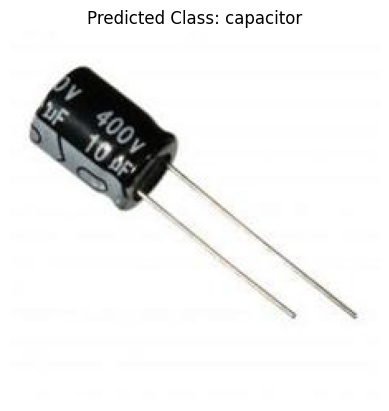

Image: Capacitor (4756).jpg
Predicted Class: capacitor
Probabilities: [9.9886596e-01 1.1339176e-03 9.0624637e-09 5.3800171e-08 2.7194313e-09]
1/1 [==============================] - 0s 29ms/step


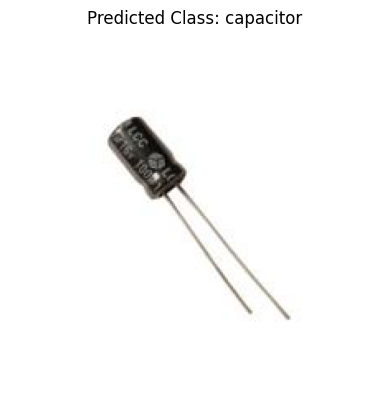

Image: Capacitor (4764).jpg
Predicted Class: capacitor
Probabilities: [9.9962604e-01 3.6832431e-04 1.0702199e-06 4.1070543e-06 4.8020473e-07]
1/1 [==============================] - 0s 24ms/step


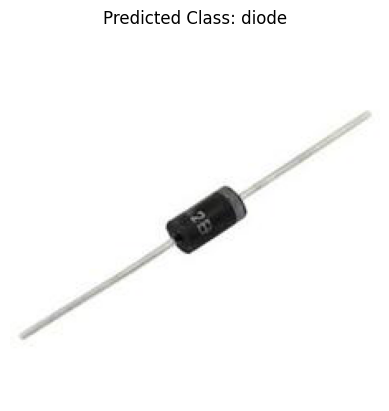

Image: diodaIN5408114.jpg
Predicted Class: diode
Probabilities: [1.3251034e-04 9.9986577e-01 4.4552104e-09 5.6054622e-10 1.6259071e-06]
1/1 [==============================] - 0s 23ms/step


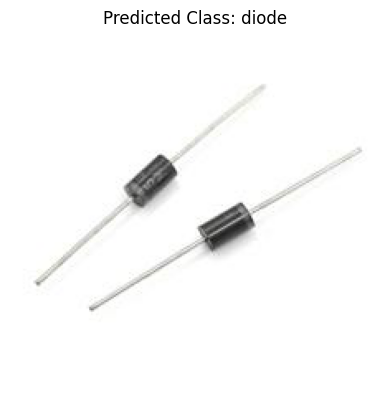

Image: diodaIN5408175.jpg
Predicted Class: diode
Probabilities: [1.3093848e-04 9.9974686e-01 5.2454413e-10 4.9751206e-06 1.1710561e-04]
1/1 [==============================] - 0s 25ms/step


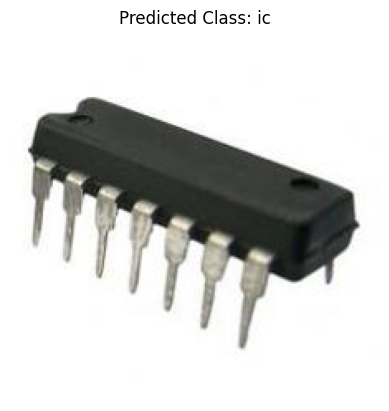

Image: IC (720).jpg
Predicted Class: ic
Probabilities: [3.3767112e-06 2.8163693e-06 9.9969077e-01 3.0294378e-04 9.7668220e-08]
1/1 [==============================] - 0s 34ms/step


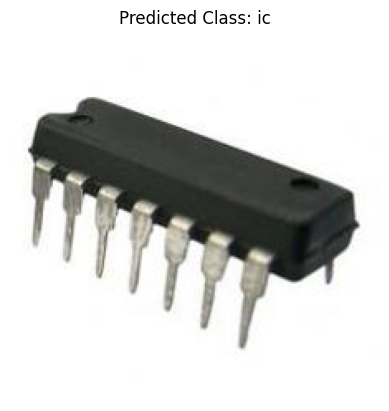

Image: IC (744).jpg
Predicted Class: ic
Probabilities: [3.3767112e-06 2.8163693e-06 9.9969077e-01 3.0294378e-04 9.7668220e-08]
1/1 [==============================] - 0s 26ms/step


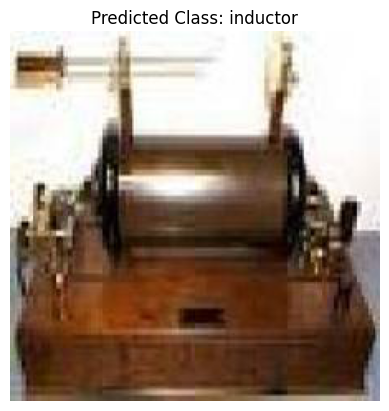

Image: induction-coil019.jpg
Predicted Class: inductor
Probabilities: [1.1619482e-11 2.6760662e-03 2.8536208e-06 9.9732107e-01 8.9077141e-11]
1/1 [==============================] - 0s 33ms/step


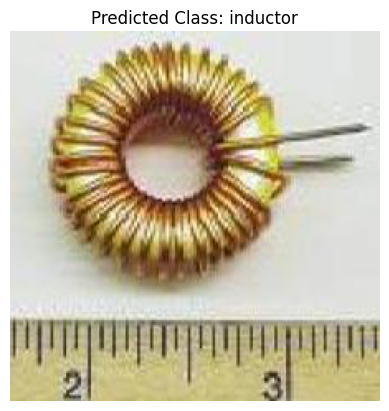

Image: induction-coil059.jpg
Predicted Class: inductor
Probabilities: [3.4523987e-06 8.0561796e-03 4.9633218e-07 9.9193925e-01 7.0506439e-07]
1/1 [==============================] - 0s 34ms/step


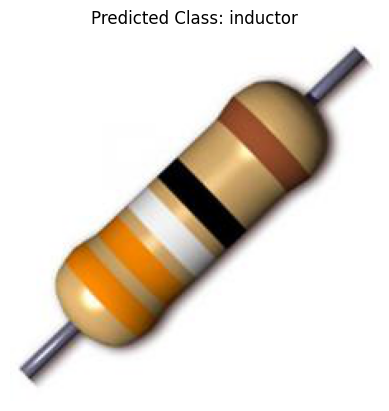

Image: Resistor (5).jpg
Predicted Class: inductor
Probabilities: [4.8131060e-08 6.9947778e-06 3.3100103e-11 7.6201195e-01 2.3798095e-01]
1/1 [==============================] - 0s 34ms/step


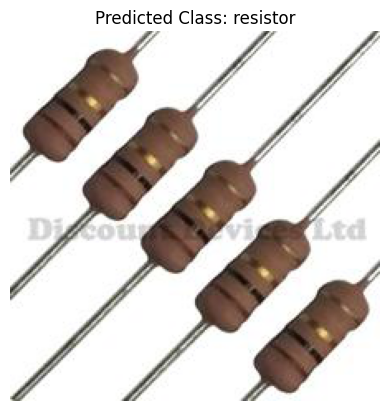

Image: Resistor (11).jpg
Predicted Class: resistor
Probabilities: [2.9650632e-01 1.3233244e-01 8.8562535e-09 9.1546178e-03 5.6200659e-01]
1/1 [==============================] - 0s 31ms/step


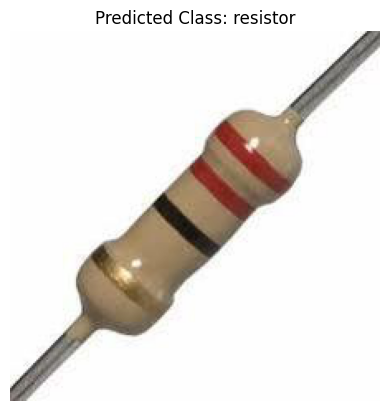

Image: Resistor (17).jpg
Predicted Class: resistor
Probabilities: [6.4224032e-10 1.3044659e-03 8.9133709e-15 1.9253977e-07 9.9869531e-01]


In [45]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()


for fn in uploaded.keys():
    # Load and preprocess the image
    img = Image.open(fn)
    img = img.resize((224, 224))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make the prediction
    predictions = model.predict(x)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title('Predicted Class: {}'.format(predicted_class_name))
    plt.axis('off')
    plt.show()

    print("Image:", fn)
    print("Predicted Class:", predicted_class_name)
    print("Probabilities:", predictions[0])



In [46]:
from sklearn.metrics import classification_report

validation_steps = len(validation_generator)
y_true = []
for _ in range(validation_steps):
    _, labels = validation_generator.next()
    y_true.extend(np.argmax(labels, axis=1))

y_pred_probabilities = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

report = classification_report(y_true, y_pred, target_names=class_names)

print(report)


24/24 [==============================] - 2s 67ms/step
              precision    recall  f1-score   support

   capacitor       0.91      0.99      0.95       150
       diode       0.89      0.88      0.88       150
          ic       0.97      0.98      0.98       150
    inductor       0.93      0.94      0.94       150
    resistor       0.96      0.88      0.92       150

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



In [47]:
model.save('model1.h5')

In [ ]:
from google.colab import files
files.download("model1.h5")
files.download("labels.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>